<a href="https://colab.research.google.com/github/Tayyab-Shehzad/BOOTCAMP2020/blob/master/Thesis%20Paractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving tweets_thesis (1).csv to tweets_thesis (1).csv
User uploaded file "tweets_thesis (1).csv" with length 6888934 bytes


In [2]:
import io
import pandas as pd 
import numpy as np
from numpy import mean
from numpy import std

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

#import reguler expression 
import re

#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

#import sklearn for modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, svm, naive_bayes
from sklearn.model_selection import train_test_split

#sklearn for stacking
from sklearn import model_selection
from mlxtend.classifier import StackingClassifier

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#visualization 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [3]:
df =pd.read_csv(io.StringIO(uploaded['tweets_thesis (1).csv'].decode('utf-8')))
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [4]:
df.isnull().sum()

clean_comment    100
category           0
dtype: int64

In [5]:
df_drop = df.dropna()
df_drop.shape

(37149, 2)

In [6]:
df_drop = df_drop.drop_duplicates()
df_drop.shape

(36799, 2)

In [7]:
#count sentiment 
sentiment = df_drop.groupby(['category'])['category'].count()
sentiment

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['tweet_count'] = chart['category']
chart.drop(['category'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['tweet_count']/chart['tweet_count'].sum()
chart

,category,tweet_count,percent
0,-1,8250,0.224191
1,0,12778,0.347238
2,1,15771,0.428571


Text(0.5, 1.0, 'Sentiment Class')

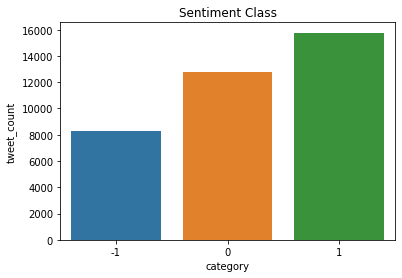

In [8]:
#visualization 
ax = sns.barplot(x= 'category', y='tweet_count', data=chart)
ax.set_title('Sentiment Class')

In [9]:
stop = stopwords.words('english')
df_drop['clean_comment'] = df_drop['clean_comment'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [10]:
df_drop.head(5)

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal wrappi...,0
4,benefit may want read living buddha living chr...,1


In [15]:
rare_word = pd.Series(' '.join(df_drop['clean_comment']).split()).value_counts()[-100:]
print(len(rare_word))
rare_word

100


fuccking        1
opacity         1
119030100873    1
koan            1
pater           1
               ..
basements       1
crawl           1
nayeons         1
“most           1
fsu             1
Length: 100, dtype: int64

In [16]:
rare_word = list(rare_word.index)
df_drop['clean_comment'] = df_drop['clean_comment'].apply(lambda x: " ".join(x for x in x.split() if x not in rare_word))
df_drop['clean_comment'].head(5)

0    family mormon never tried explain still stare ...
1    buddhism much lot compatible christianity espe...
2    seriously say thing first get complex explain ...
3    learned want teach different focus goal wrappi...
4    benefit may want read living buddha living chr...
Name: clean_comment, dtype: object

In [17]:
st = PorterStemmer()
df_drop['clean_comment'] = df_drop['clean_comment'][:].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [18]:
df_drop.head(5)

,clean_comment,category
0,famili mormon never tri explain still stare pu...,1
1,buddhism much lot compat christian especi cons...,1
2,serious say thing first get complex explain no...,-1
3,learn want teach differ focu goal wrap paper b...,0
4,benefit may want read live buddha live christ ...,1


TF/IDF

In [22]:
from nltk.tokenize import RegexpTokenizer
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
tf = TfidfVectorizer(min_df=5, max_df=0.90, sublinear_tf = True,use_idf = True,ngram_range=(1,1),tokenizer = token.tokenize)
text_tf = tf.fit_transform(df_drop['clean_comment'])
np.shape(text_tf)

(36799, 9497)

Bag of Words

In [23]:
from nltk.tokenize import RegexpTokenizer
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df_drop['clean_comment'])
np.shape(text_counts)

(36799, 39099)

Split on TF/IDF

In [24]:
X = text_tf
y = df_drop['category']

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, df_drop['category'], test_size=0.3, random_state=123)

Implementation of Mutual Information

In [26]:
#determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
select_k_features = SelectKBest(mutual_info_classif, k=3000)
select_k_features.fit(X_train, y_train)
select_k_features.scores_

array([4.23981624e-03, 1.15957677e-04, 8.01696724e-03, ...,
       2.88411076e-04, 5.79762368e-05, 4.19702326e-04])

In [27]:
mutual_info_train_X= select_k_features.transform(X_train)
mutual_info_test_X= select_k_features.transform(X_test)

In [28]:
Lr_mutual_info = LogisticRegression()
Lr_mutual_info.fit(mutual_info_train_X,y_train)
Lr_pred_mutual_info_train = Lr_mutual_info.predict(mutual_info_train_X)
Lr_pred_mutual_info_test = Lr_mutual_info.predict(mutual_info_test_X)

In [30]:
print("___________________ Logistic Regression With Mutual Information ____________________")

Lr_recall_mutual_info_train = recall_score(y_train, Lr_pred_mutual_info_train, average="micro")
Lr_recall_mutual_info_test = recall_score(y_test, Lr_pred_mutual_info_test,average="micro") 

Lr_precision_mutual_info_train = precision_score(y_train, Lr_pred_mutual_info_train,average="micro")
Lr_precision_mutual_info_test = precision_score(y_test, Lr_pred_mutual_info_test,average="micro")

Lr_f1_score_mutual_info_train = f1_score(y_train, Lr_pred_mutual_info_train,average="micro")
Lr_f1_score_mutual_info_test = f1_score(y_test, Lr_pred_mutual_info_test,average="micro")

print('Logistic Regression :')
print('Recall train & test     : %.2f%%' % (Lr_recall_mutual_info_train * 100), '&', '%.2f%%' % (Lr_recall_mutual_info_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_mutual_info_train * 100), '&', '%.2f%%' % (Lr_precision_mutual_info_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_mutual_info_train * 100), '&', '%.2f%%' % (Lr_f1_score_mutual_info_test * 100))

___________________ Logistic Regression With Mutual Information ____________________
Logistic Regression :
Recall train & test     : 86.47% & 82.14%
Precision train & test  : 86.47% & 82.14%
F1 Score train & test   : 86.47% & 82.14%


In [31]:
SVM_mutual_info = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_mutual_info.fit(mutual_info_train_X,y_train)
SVM_pred_mutual_info_train = SVM_mutual_info.predict(mutual_info_train_X)
SVM_pred_mutual_info_test = SVM_mutual_info.predict(mutual_info_test_X)

In [32]:
print("___________________ SVM With Mutual Information ____________________")

SVM_recall_mutual_info_train = recall_score(y_train, SVM_pred_mutual_info_train, average="micro")
SVM_recall_mutual_info_test = recall_score(y_test, SVM_pred_mutual_info_test,average="micro") 

SVM_precision_mutual_info_train = precision_score(y_train, SVM_pred_mutual_info_train,average="micro")
SVM_precision_mutual_info_test = precision_score(y_test, SVM_pred_mutual_info_test,average="micro")

SVM_f1_score_mutual_info_train = f1_score(y_train, SVM_pred_mutual_info_train,average="micro")
SVM_f1_score_mutual_info_test = f1_score(y_test, SVM_pred_mutual_info_test,average="micro")

print('Support Vector Machine :')
print('Recall train & test     : %.2f%%' % (SVM_recall_mutual_info_train * 100), '&', '%.2f%%' % (SVM_recall_mutual_info_test * 100))
print('Precision train & test  : %.2f%%' % (SVM_precision_mutual_info_train * 100), '&', '%.2f%%' % (SVM_precision_mutual_info_test * 100))
print('F1 Score train & test   : %.2f%%' % (SVM_f1_score_mutual_info_train * 100), '&', '%.2f%%' % (SVM_f1_score_mutual_info_test * 100))

___________________ SVM With Mutual Information ____________________
Support Vector Machine :
Recall train & test     : 87.56% & 83.36%
Precision train & test  : 87.56% & 83.36%
F1 Score train & test   : 87.56% & 83.36%


In [33]:
NB_mutual_info = naive_bayes.MultinomialNB()
NB_mutual_info.fit(mutual_info_train_X,y_train)
NB_pred_mutual_info_train = NB_mutual_info.predict(mutual_info_train_X)
NB_pred_mutual_info_test = NB_mutual_info.predict(mutual_info_test_X)

In [34]:
print("___________________  MultinomialNB With Mutual Information ____________________")

NB_recall_mutual_info_train = recall_score(y_train, NB_pred_mutual_info_train, average="micro")
NB_recall_mutual_info_test = recall_score(y_test, NB_pred_mutual_info_test,average="micro") 

NB_precision_mutual_info_train = precision_score(y_train, NB_pred_mutual_info_train,average="micro")
NB_precision_mutual_info_test = precision_score(y_test, NB_pred_mutual_info_test,average="micro")

NB_f1_score_mutual_info_train = f1_score(y_train, NB_pred_mutual_info_train,average="micro")
NB_f1_score_mutual_info_test = f1_score(y_test, NB_pred_mutual_info_test,average="micro")

print('Multinomial Naive Bayes :')
print('Recall train & test     : %.2f%%' % (NB_recall_mutual_info_train * 100), '&', '%.2f%%' % (NB_recall_mutual_info_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_mutual_info_train * 100), '&', '%.2f%%' % (NB_precision_mutual_info_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_mutual_info_train * 100), '&', '%.2f%%' % (NB_f1_score_mutual_info_test * 100))

___________________  MultinomialNB With Mutual Information ____________________
Multinomial Naive Bayes :
Recall train & test     : 67.90% & 63.01%
Precision train & test  : 67.90% & 63.01%
F1 Score train & test   : 67.90% & 63.01%


In [35]:
RF_mutual_info = RandomForestClassifier(n_estimators=100)
RF_mutual_info.fit(mutual_info_train_X,y_train)
RF_pred_mutual_info_train = RF_mutual_info.predict(mutual_info_train_X)
RF_pred_mutual_info_test = RF_mutual_info.predict(mutual_info_test_X)

In [36]:
print("___________________  Random Forest With Mutual Information ____________________")

RF_recall_mutual_info_train = recall_score(y_train, RF_pred_mutual_info_train, average="micro")
RF_recall_mutual_info_test = recall_score(y_test, RF_pred_mutual_info_test,average="micro") 

RF_precision_mutual_info_train = precision_score(y_train, RF_pred_mutual_info_train,average="micro")
RF_precision_mutual_info_test = precision_score(y_test, RF_pred_mutual_info_test,average="micro")

RF_f1_score_mutual_info_train = f1_score(y_train, RF_pred_mutual_info_train,average="micro")
RF_f1_score_mutual_info_test = f1_score(y_test, RF_pred_mutual_info_test,average="micro")

print('Random Forest :')
print('Recall train & test     : %.2f%%' % (RF_recall_mutual_info_train * 100), '&', '%.2f%%' % (RF_recall_mutual_info_test * 100))
print('Precision train & test  : %.2f%%' % (RF_precision_mutual_info_train * 100), '&', '%.2f%%' % (RF_precision_mutual_info_test * 100))
print('F1 Score train & test   : %.2f%%' % (RF_f1_score_mutual_info_train * 100), '&', '%.2f%%' % (RF_f1_score_mutual_info_test * 100))

___________________  Random Forest With Mutual Information ____________________
Random Forest :
Recall train & test     : 99.77% & 79.46%
Precision train & test  : 99.77% & 79.46%
F1 Score train & test   : 99.77% & 79.46%


Mutual_Info, Stacking With SVM as Meta Classifier

In [37]:
clf1 = LogisticRegression()
clf2 = RandomForestClassifier(random_state=1)
clf3 = naive_bayes.MultinomialNB()
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=SVM)

In [38]:
print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['Logistic Regression', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier SVM']):

    scores = model_selection.cross_val_score(clf, mutual_info_train_X, y_train, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.80 (+/- 0.00) [Logistic Regression]
Accuracy: 0.79 (+/- 0.00) [Random Forest]
Accuracy: 0.61 (+/- 0.01) [Naive Bayes]
Accuracy: 0.79 (+/- 0.00) [StackingClassifier SVM]


Impelemntation of Chi Square

In [39]:
test = SelectKBest(score_func=chi2, k=3000)
fit = test.fit(X_train, y_train)
fit.scores_

array([2.62803717, 2.11268971, 0.87853982, ..., 0.28399853, 1.34040848,
       0.6507328 ])

In [40]:
ch_square_train_X= fit.transform(X_train)
ch_square_test_X= fit.transform(X_test)

In [41]:
Lr_chsquare = LogisticRegression()
Lr_chsquare.fit(ch_square_train_X,y_train)
Lr_pred_chsquare_train = Lr_chsquare.predict(ch_square_train_X)
Lr_pred_chsquare_test = Lr_chsquare.predict(ch_square_test_X)

In [42]:

print("___________________ Logistic Regression With Chi-Square ____________________")

Lr_recall_chsquare_train = recall_score(y_train, Lr_pred_chsquare_train, average="micro")
Lr_recall_chsquare_test = recall_score(y_test, Lr_pred_chsquare_test,average="micro") 

Lr_precision_chsquare_train = precision_score(y_train, Lr_pred_chsquare_train,average="micro")
Lr_precision_chsquare_test = precision_score(y_test, Lr_pred_chsquare_test,average="micro")

Lr_f1_score_chsquare_train = f1_score(y_train, Lr_pred_chsquare_train,average="micro")
Lr_f1_score_chsquare_test = f1_score(y_test, Lr_pred_chsquare_test,average="micro")

print('Logistic Regression :')
print('Recall train & test     : %.2f%%' % (Lr_recall_chsquare_train * 100), '&', '%.2f%%' % (Lr_recall_chsquare_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_chsquare_train * 100), '&', '%.2f%%' % (Lr_precision_chsquare_test * 100))
print('F1 Score train & test   : %.2f%%' % (Lr_f1_score_chsquare_train * 100), '&', '%.2f%%' % (Lr_f1_score_chsquare_test * 100))

___________________ Logistic Regression With Chi-Square ____________________
Logistic Regression :
Recall train & test     : 86.54% & 82.67%
Precision train & test  : 86.54% & 82.67%
F1 Score train & test   : 86.54% & 82.67%


In [43]:
SVM_chsquare = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_chsquare.fit(ch_square_train_X,y_train)
SVM_pred_chsquare_train = SVM_chsquare.predict(ch_square_train_X)
SVM_pred_chsquare_test = SVM_chsquare.predict(ch_square_test_X)

In [44]:
print("___________________ SVM With Chi-Square ____________________")

SVM_recall_chsquare_train = recall_score(y_train, SVM_pred_chsquare_train, average="micro")
SVM_recall_chsquare_test = recall_score(y_test, SVM_pred_chsquare_test,average="micro") 

SVM_precision_chsquare_train = precision_score(y_train, SVM_pred_chsquare_train,average="micro")
SVM_precision_chsquare_test = precision_score(y_test, SVM_pred_chsquare_test,average="micro")

SVM_f1_score_chsquare_train = f1_score(y_train, SVM_pred_chsquare_train,average="micro")
SVM_f1_score_chsquare_test = f1_score(y_test, SVM_pred_chsquare_test,average="micro")

print('Support Vector Machine :')
print('Recall train & test     : %.2f%%' % (SVM_recall_chsquare_train * 100), '&', '%.2f%%' % (SVM_recall_chsquare_test * 100))
print('Precision train & test  : %.2f%%' % (SVM_precision_chsquare_train * 100), '&', '%.2f%%' % (SVM_precision_chsquare_test * 100))
print('F1 Score train & test   : %.2f%%' % (SVM_f1_score_chsquare_train * 100), '&', '%.2f%%' % (SVM_f1_score_chsquare_test * 100))

___________________ SVM With Chi-Square ____________________
Support Vector Machine :
Recall train & test     : 88.09% & 84.12%
Precision train & test  : 88.09% & 84.12%
F1 Score train & test   : 88.09% & 84.12%


In [45]:
NB_chsquare = naive_bayes.MultinomialNB()
NB_chsquare.fit(ch_square_train_X,y_train)
NB_pred_chsquare_train = NB_chsquare.predict(ch_square_train_X)
NB_pred_chsquare_test = NB_chsquare.predict(ch_square_test_X)

In [46]:
print("___________________  MultinomialNB()NB With Chi-Square ____________________")

NB_recall_chsquare_train = recall_score(y_train, NB_pred_chsquare_train, average="micro")
NB_recall_chsquare_test = recall_score(y_test, NB_pred_chsquare_test,average="micro") 

NB_precision_chsquare_train = precision_score(y_train, NB_pred_chsquare_train,average="micro")
NB_precision_chsquare_test = precision_score(y_test, NB_pred_chsquare_test,average="micro")

NB_f1_score_chsquare_train = f1_score(y_train, NB_pred_chsquare_train,average="micro")
NB_f1_score_chsquare_test = f1_score(y_test, NB_pred_chsquare_test,average="micro")

print('Multinomial Naive Bayes :')
print('Recall train & test     : %.2f%%' % (NB_recall_chsquare_train * 100), '&', '%.2f%%' % (NB_recall_chsquare_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_chsquare_train * 100), '&', '%.2f%%' % (NB_precision_chsquare_test * 100))
print('F1 Score train & test   : %.2f%%' % (NB_f1_score_chsquare_train * 100), '&', '%.2f%%' % (NB_f1_score_chsquare_test * 100))

___________________  MultinomialNB()NB With Chi-Square ____________________
Multinomial Naive Bayes :
Recall train & test     : 62.38% & 57.70%
Precision train & test  : 62.38% & 57.70%
F1 Score train & test   : 62.38% & 57.70%


In [47]:
RF_chsquare = RandomForestClassifier(n_estimators=100)
RF_chsquare.fit(ch_square_train_X,y_train)
RF_pred_chsquare_train = RF_chsquare.predict(ch_square_train_X)
RF_pred_chsquare_test = RF_chsquare.predict(ch_square_test_X)

In [48]:
print("___________________  Random Forest With Chi-Square ____________________")

RF_recall_chsquare_train = recall_score(y_train, RF_pred_chsquare_train, average="micro")
RF_recall_chsquare_test = recall_score(y_test, RF_pred_chsquare_test,average="micro") 

RF_precision_chsquare_train = precision_score(y_train, RF_pred_chsquare_train,average="micro")
RF_precision_chsquare_test = precision_score(y_test, RF_pred_chsquare_test,average="micro")

RF_f1_score_chsquare_train = f1_score(y_train, RF_pred_chsquare_train,average="micro")
RF_f1_score_chsquare_test = f1_score(y_test, RF_pred_chsquare_test,average="micro")

print('Random Forest :')
print('Recall train & test     : %.2f%%' % (RF_recall_chsquare_train * 100), '&', '%.2f%%' % (RF_recall_chsquare_test * 100))
print('Precision train & test  : %.2f%%' % (RF_precision_chsquare_train * 100), '&', '%.2f%%' % (RF_precision_chsquare_test * 100))
print('F1 Score train & test   : %.2f%%' % (RF_f1_score_chsquare_train * 100), '&', '%.2f%%' % (RF_f1_score_chsquare_test * 100))

___________________  Random Forest With Chi-Square ____________________
Random Forest :
Recall train & test     : 99.82% & 79.36%
Precision train & test  : 99.82% & 79.36%
F1 Score train & test   : 99.82% & 79.36%


Chi-Square, Stacking With SVM as Meta Classifier

In [49]:
clf1 = LogisticRegression()
clf2 = RandomForestClassifier(random_state=1)
clf3 = naive_bayes.MultinomialNB()
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=SVM)

In [50]:
print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['Logistic Regression', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier SVM']):

    scores = model_selection.cross_val_score(clf, ch_square_train_X, y_train, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.81 (+/- 0.00) [Logistic Regression]
Accuracy: 0.79 (+/- 0.00) [Random Forest]
Accuracy: 0.59 (+/- 0.00) [Naive Bayes]
Accuracy: 0.79 (+/- 0.00) [StackingClassifier SVM]
